In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Constants
MAX_CARS = 20
MAX_MOVE = 5
RENTAL_REWARD = 10
MOVEMENT_COST = 2
DISCOUNT_FACTOR = 0.9

REQUEST_MEAN_L1 = 3  # Poisson mean for location 1 requests
RETURN_MEAN_L1 = 3   # Poisson mean for location 1 returns
REQUEST_MEAN_L2 = 4  # Poisson mean for location 2 requests
RETURN_MEAN_L2 = 2   # Poisson mean for location 2 returns

In [2]:
def poisson(lda,x):
    return stats.poisson.pmf(x, lda)
def poissonc(lda,x):
    return stats.poisson.cdf(x, lda)

In [3]:
state_space = [(x1, x2) for x1 in range(MAX_CARS + 1) for x2 in range(MAX_CARS + 1)]

In [4]:
L1_rent = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1,car2 in state_space:
    if car2 == 0:
        L1_rent[car1,car2]  = 1 - poissonc(REQUEST_MEAN_L1,car1-car2-1)
    else:
        L1_rent[car1,car2]  = poisson(REQUEST_MEAN_L1,car1-car2)

L1_return = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1,car2 in state_space:
    if car2 == MAX_CARS:
        L1_return[car1,car2]  = 1- poissonc(RETURN_MEAN_L1,car2-car1-1)
    else:
        L1_return[car1,car2]  = poisson(RETURN_MEAN_L1,car2-car1)

L2_rent = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1,car2 in state_space:
    if car2 == 0:
        L2_rent[car1,car2]  = 1 - poissonc(REQUEST_MEAN_L2,car1-car2-1)
    else:
        L2_rent[car1,car2]  = poisson(REQUEST_MEAN_L2,car1-car2)

L2_return = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1,car2 in state_space:
    if car2 == MAX_CARS:
        L2_return[car1,car2]  = 1- poissonc(RETURN_MEAN_L2,car2-car1-1)
    else:
        L2_return[car1,car2]  = poisson(RETURN_MEAN_L2,car2-car1)

In [5]:
transition_prob = np.zeros((MAX_CARS + 1, MAX_CARS + 1, MAX_CARS+1, MAX_CARS+1))
rewards = np.zeros((MAX_CARS + 1, MAX_CARS + 1,MAX_CARS+1,MAX_CARS+1))
for L1_car1,L1_car2 in state_space:
    for L2_car1,L2_car2 in state_space: 
        prob = 0
        reward = 0
        for L1_mid ,L2_mid in state_space:
            p1 = L1_rent[L1_car1,L1_mid]*L1_return[L1_mid,L1_car2]
            p2 = L2_rent[L2_car1,L2_mid]*L2_return[L2_mid,L2_car2]
            prob += p1*p2
            reward += p1*p2*(L1_car1+L2_car1-L1_mid-L2_mid)*RENTAL_REWARD
        transition_prob[L1_car1,L1_car2,L2_car1,L2_car2] = prob
        rewards[L1_car1,L1_car2,L2_car1,L2_car2] = reward/prob

In [6]:
def p(state,state_prime):
    return transition_prob[state[0],state_prime[0],state[1],state_prime[1]]
def r(state,state_prime):
    return rewards[state[0],state_prime[0],state[1],state_prime[1]]

In [7]:
def sum_p(state,action,V):
    s1 = min(state[0]+action,MAX_CARS)
    s2 = min(state[1]-action,MAX_CARS)
    s = (s1,s2)
    v = -abs(action)*2
    for s1 in range(MAX_CARS+1):
        for s2 in range(MAX_CARS+1):
            s_= (s1,s2)
            v+= p(s,s_)*(r(s,s_)+DISCOUNT_FACTOR*V[s_])
    return v


In [8]:
# Plot the policy change (heatmap) for the current iteration
def plot_policy(policy, iteration):
    # Prepare a 21x21 grid for policy visualization
    policy_grid = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    
    # Fill in the grid with actions from the policy
    for x1 in range(MAX_CARS + 1):
        for x2 in range(MAX_CARS + 1):
            policy_grid[x1, x2] = policy[(x1, x2)]

    # Plot the heatmap (we can choose different colors for actions)
    plt.figure(figsize=(6, 5))
    plt.imshow(policy_grid, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Number of Cars Moved')
    plt.title(f'Policy at Iteration {iteration}')
    plt.xlabel('Location 2 Cars')
    plt.ylabel('Location 1 Cars')
    plt.xticks(np.arange(0, MAX_CARS + 1, 5))
    plt.yticks(np.arange(0, MAX_CARS + 1, 5))
    plt.show()


In [9]:
def policy_iteration():
    policy = {(x1, x2): 0 for (x1, x2) in state_space}
    
    V = {(x1, x2): 0 for (x1, x2) in state_space}
    
    def policy_evaluation():
        tolerance = 0.00001  # Convergence tolerance
        while True:
            delta = 0
            for state in state_space:
                v = V[state]
                action = policy[state]
                V[state] = sum_p(state,action,V)
                delta = max(delta, abs(v - V[state]))
            if delta < tolerance:
                break

    def policy_improvement():
        policy_stable = True
        for state in state_space:
            old_action = policy[state]
            MAX_MOVE1 = min(MAX_MOVE,state[0])
            MAX_MOVE2 = min(MAX_MOVE,state[1])

            action_space = list(range(-MAX_MOVE1, MAX_MOVE2 + 1))
            action_values = []
            for action in action_space:
                action_value = sum_p(state,action,V)
                action_values.append(action_value)
            best_action = action_space[np.argmax(action_values)]
            policy[state] = best_action
            if old_action != best_action:
                policy_stable = False
        return policy_stable

    # Iterate until the policy converges
    iteration = 0
    while True:
        print(f"Iteration {iteration}: Policy")
        plot_policy(policy, iteration)  
        policy_evaluation()
        if policy_improvement():
            plot_policy(policy, iteration)
            break
        iteration += 1


Iteration 0: Policy


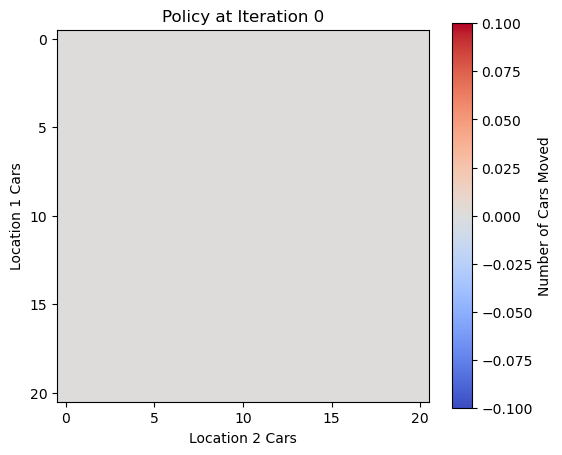

Iteration 1: Policy


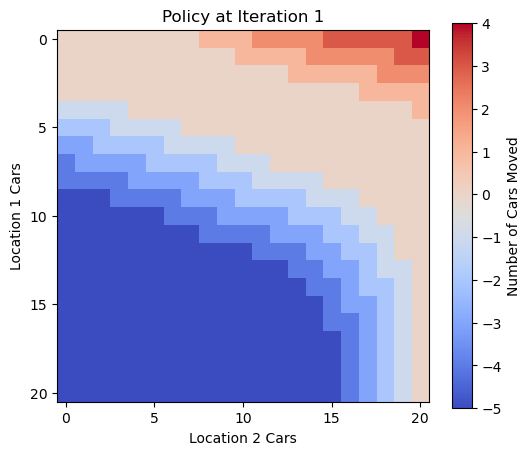

Iteration 2: Policy


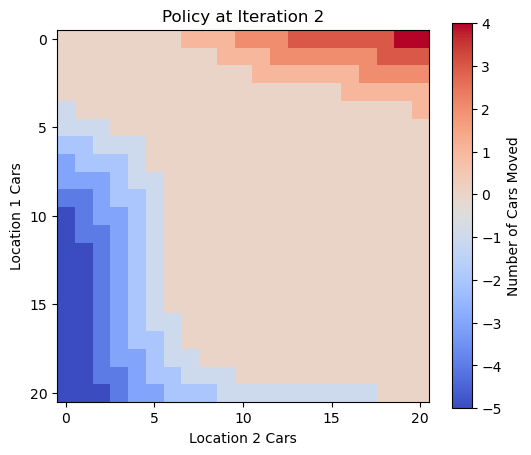

Iteration 3: Policy


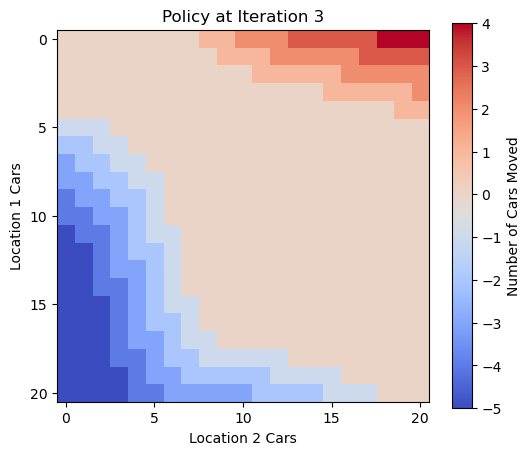

Iteration 4: Policy


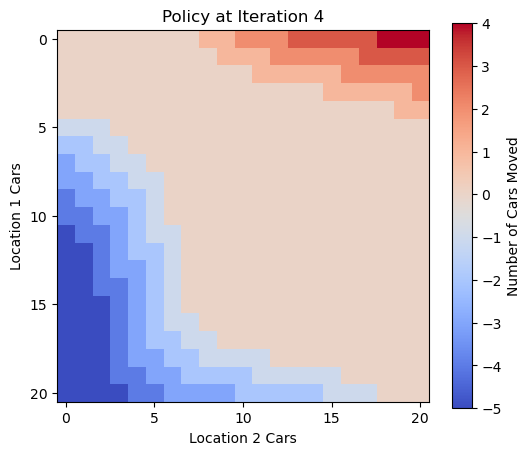

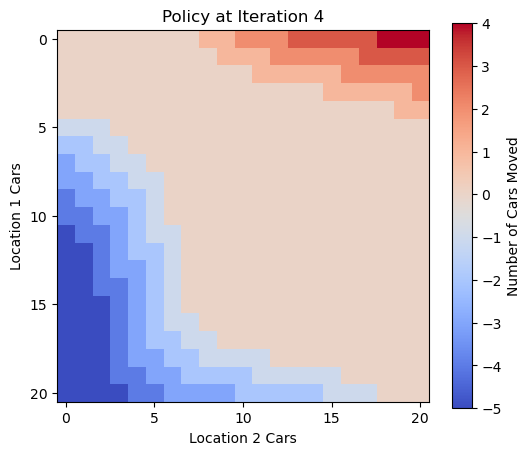

In [10]:
# Run the policy iteration
policy_iteration()